# Kernel Mixture Network with Edward and Keras

In [2]:
sys.path.append('../')

import numpy as np
import pandas as pd

# neural networks
import edward as ed
import tensorflow as tf

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# module loading settings
%load_ext autoreload
%autoreload 2

Create dummy dataset. Source: http://edwardlib.org/tutorials/mixture-density-network

Size of features in training data: (3750, 1)
Size of output in training data: (3750,)
Size of features in test data: (1250, 1)
Size of output in test data: (1250,)


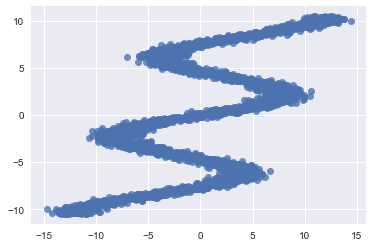

In [3]:
from sklearn.model_selection import train_test_split

def build_toy_dataset(n):
    y_data = np.random.uniform(-10.5, 10.5, n)
    r_data = np.random.normal(size=n)  # random noise
    x_data = np.sin(0.75 * y_data) * 7.0 + y_data * 0.5 + r_data * 1.0
    x_data = x_data.reshape((n, 1))
    return train_test_split(x_data, y_data, random_state=42)

n_observations = 5000  # number of data points
n_features = 1  # number of features

X_train, X_test, y_train, y_test = build_toy_dataset(n_observations)
print("Size of features in training data: {}".format(X_train.shape))
print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

sns.regplot(X_train, y_train, fit_reg=False);

Function to define kernel centers with various downsampling alternatives.

In [4]:
from sklearn.cluster import KMeans, AgglomerativeClustering

def sample_center_points(y, method='all', k=100, keep_edges=False):

    y = y.ravel()

    # Keep all points as kernel centers
    if method is 'all':
        return y

    # Remove outer points to keep expressiveness at the borders
    if keep_edges:
        y = np.sort(y)
        centers = np.array([y[0], y[-1]])
        y = y[1:-1]
        # adjust k such that the final output has size k
        k -= 2
    else:
        centers = np.empty(0)

    # Use agglomerative clustering to determine k output points plus the two end points
    if method is 'agglomerative':
        model = AgglomerativeClustering(n_clusters=k, linkage='complete')
        model.fit(y.reshape(-1, 1))
        labels = pd.Series(model.labels_, name='label')
        y_s = pd.Series(y, name='y')
        df = pd.concat([y_s, labels], axis=1)
        cluster_centers = df.groupby('label')['y'].mean().values

    return np.append(centers, cluster_centers)

Model definition.

In [5]:
from edward.models import Categorical, Mixture, Normal
from keras.layers import Dense, Dropout
from src.kmn import sample_center_points

X_ph = tf.placeholder(tf.float32, [None, n_features])
y_ph = tf.placeholder(tf.float32, [None])
y_grid_ph = tf.placeholder(tf.float32)

batch_size = tf.shape(X_ph)[0]

n_locs = 20
locs = sample_center_points(y_train, method='agglomerative', k=n_locs)
locs_array = tf.unstack(tf.transpose(tf.multiply(tf.ones((batch_size, n_locs)), locs)))

init_scales = np.array([0.1, 1.])
n_scales = len(init_scales)
scales = tf.nn.softplus(tf.Variable(init_scales, dtype=tf.float32, trainable=True))
scales_array = tf.unstack(tf.transpose(tf.multiply(tf.ones((batch_size, n_scales)), scales)))

# keras model
x = Dense(15, activation='relu')(X_ph)
x = Dense(15, activation='relu')(x)
x = Dropout(rate=0.5)(x, training=True)
weights = Dense(n_locs * n_scales, activation='softplus')(x)

cat = Categorical(logits=weights)
components = [Normal(loc=loc, scale=scale) for loc in locs_array for scale in scales_array]
y = Mixture(cat=cat, components=components, value=tf.zeros_like(y_ph))

n_samples = 10
samples = y.sample(sample_shape=(n_samples))
densities = tf.transpose(y.prob(tf.reshape(y_grid_ph,(-1,1))))

Initialize inference.

In [8]:
inference = ed.MAP(data={y: y_ph})
inference.initialize(var_list=tf.trainable_variables())
sess = ed.get_session()
tf.global_variables_initializer().run()

Run inference.

In [9]:
n_epoch = 400
train_loss = np.zeros(n_epoch)
test_loss = np.zeros(n_epoch)
for i in range(n_epoch):
    info_dict = inference.update(feed_dict={X_ph: X_train, y_ph: y_train})
    train_loss[i] = info_dict['loss']
    test_loss[i] = sess.run(inference.loss, feed_dict={X_ph: X_test, y_ph: y_test})
    inference.print_progress(info_dict)
    
print("optimal bandwiths: {}".format(sess.run(scales)))

 400/1000 [ 40%] ████████████                   ETA: 14s | Loss: 6878.889   optimal bandwiths: [ 0.33788055  0.47959098]


Plot loss over epochs.

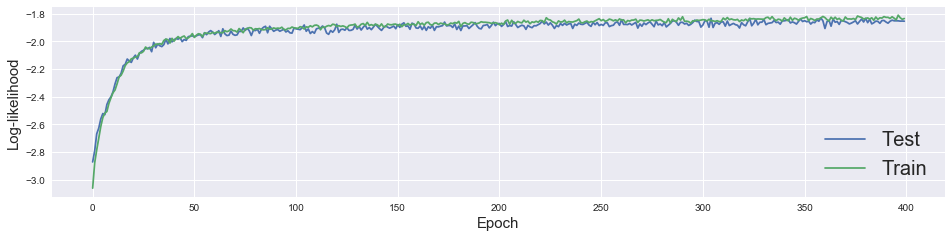

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(n_epoch), -test_loss / len(X_test), label='Test')
plt.plot(np.arange(n_epoch), -train_loss / len(X_train), label='Train')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Log-likelihood', fontsize=15)
plt.show()

Sample from the mixtures.

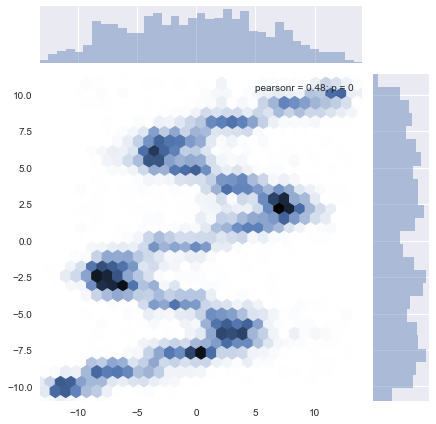

In [11]:
s = sess.run(samples, feed_dict={X_ph: X_test})
xs = np.tile(X_test.ravel(), n_samples)
ys = s.flatten()   
sns.jointplot(xs, ys, kind="hex");

Predict density for a single sample. We can optinally use dropout-at-test to get uncertainty estimates of the conditional density.

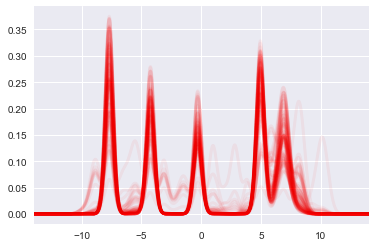

In [12]:
n_grid_points = 1000
y_grid = np.linspace(-14, 14, num=n_grid_points)

X_vals = np.array(np.zeros(100)).reshape(-1,1)

d = sess.run(densities, feed_dict={X_ph: X_vals, y_grid_ph: y_grid})
df = pd.DataFrame(d, index=X_vals.ravel(), columns=y_grid).transpose()
df.plot(color='red', alpha=0.05, legend=False, linewidth=3);